In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

#api = KaggleApi('kaggle competitions download -c titanic')
#api.authenticate()
#files = api.competition_download_files("titanic")

import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

Read data

In [2]:
testdata = pd.read_csv('test.csv');
traindata = pd.read_csv('train.csv');
traindata.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train = deepcopy(traindata)
test  = deepcopy(testdata)
train = train.drop(["Cabin","Name","Ticket","PassengerId"],axis=1);
test  = test.drop(["Cabin","Name","Ticket","PassengerId"],axis=1);


Encode data : Class, sex, embarked columns

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le_cla  = LabelEncoder()
le_sex  = LabelEncoder()
le_emb  = LabelEncoder()

train = train.dropna(subset=['Embarked'])

train['Sex']      = le_sex.fit_transform(train['Sex'])
train['Embarked'] = le_emb.fit_transform(train['Embarked'])

(array([40., 14., 15., 31., 79., 98., 85., 84., 73., 44., 35., 35., 29.,
        16., 13., 10.,  4.,  5.,  1.,  1.]),
 array([ 0.42 ,  4.399,  8.378, 12.357, 16.336, 20.315, 24.294, 28.273,
        32.252, 36.231, 40.21 , 44.189, 48.168, 52.147, 56.126, 60.105,
        64.084, 68.063, 72.042, 76.021, 80.   ]),
 <a list of 20 Patch objects>)

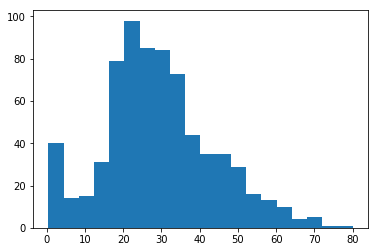

In [5]:
plt.hist(train['Age'].dropna(),bins=20)

In [6]:
# Impute missing values
#from sklearn.impute import MissingIndicator
#indicator = MissingIndicator(missing_values=-1)
#mask_missing_values_only = indicator.fit_transform([train])
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy='median', copy=True, fill_value=0)
#len(imp.fit_transform([train['Age']])[0])

# If you really want to use an imputer:
#from sklearn.preprocessing import Imputer
#imr = Imputer(missing_values='NaN', strategy='median', axis=0)
#imr.fit(train['Age'].values.reshape(-1, 1))
#imr.transform(train['Age'].values.reshape(-1,1)).shape

train['Age'].fillna(train['Age'].median(), inplace=True)


# Standardize

In [7]:
y_data  = train['Survived'].values
X_data  = train.drop(['Survived'],axis=1).values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0, stratify=y_data)

In [8]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std  = stdsc.transform(X_test)

In [16]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


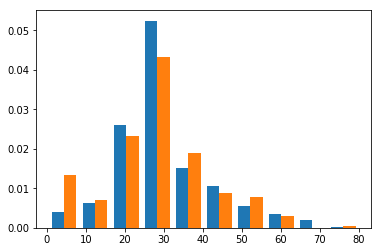

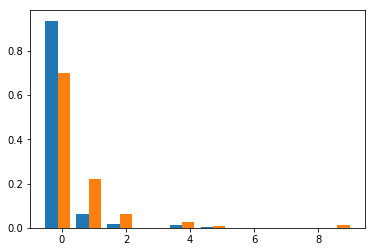

In [40]:
plt.hist([train['Age'][train['Survived']==0],train['Age'][train['Survived']==1]],normed=True); plt.show()
plt.hist([X_train_std[:,5][y_train==0],X_train_std[:,5][y_train==1]],normed=True); plt.show()

# Kernel PCA with Radial Basis functions

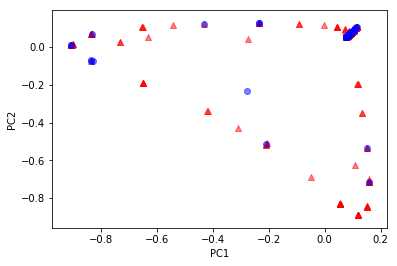

In [85]:
from sklearn.decomposition import KernelPCA
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca  = scikit_kpca.fit_transform(X_train_std)
plt.scatter(X_skernpca[y_train==0, 0], X_skernpca[y_train==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y_train==1, 0], X_skernpca[y_train==1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [89]:
def plot_decision_regions(X, y, classifier, test_idx=None,  
                          resolution=0.02):
    
    from matplotlib.colors import ListedColormap

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda  = lda.transform(X_test_std)

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

#plot_decision_regions(X_train_lda, y_train, classifier=lr)
#plot_decision_regions(X_test_lda, y_test, classifier=lr)
#plt.xlabel('LD 1')
#plt.ylabel('LD 2')
#plt.legend(loc='lower left')
#plt.show()

# Make a corner plot of just the data 